### Model preparation

In [26]:
import torch
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from torchvision.models import densenet121, densenet169
from torch.utils.data import Dataset
from torchvision import transforms



### Dataset preparation

In [27]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, dataframe=None, csv_file=None, root_dir=None, transform=None, label_map=None):
        if dataframe is not None:
            self.annotations = dataframe.reset_index(drop=True)
        elif csv_file is not None:
            self.annotations = pd.read_csv(csv_file)
        else:
            raise ValueError("This should be either dataframe or csv!")

        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map or self._build_label_map()

    def _build_label_map(self):
        labels = self.annotations['genre'].unique()
        return {label: idx for idx, label in enumerate(sorted(labels))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.iloc[idx, 0]
        subfolder = filename.split('.')[0]
        filename = filename[:-4] + '.png'
        img_name = os.path.join(self.root_dir, subfolder, filename)

        image = Image.open(img_name).convert('RGB')
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label


In [28]:
'''
from sklearn.model_selection import train_test_split
csv_file = 'project_data/tracks.csv'
df = pd.read_csv(csv_file)
df = df.sample(frac=1).reset_index(drop=True)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['genre'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['genre'])

train_df.to_csv('densenet_dataset_split/train.csv', index=False)
valid_df.to_csv('densenet_dataset_split/valid.csv', index=False)
test_df.to_csv('densenet_dataset_split/test.csv', index=False)

print("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")
'''

'\nfrom sklearn.model_selection import train_test_split\ncsv_file = \'project_data/tracks.csv\'\ndf = pd.read_csv(csv_file)\ndf = df.sample(frac=1).reset_index(drop=True)\ntrain_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[\'genre\'])\nvalid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[\'genre\'])\n\ntrain_df.to_csv(\'densenet_dataset_split/train.csv\', index=False)\nvalid_df.to_csv(\'densenet_dataset_split/valid.csv\', index=False)\ntest_df.to_csv(\'densenet_dataset_split/test.csv\', index=False)\n\nprint("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")\n'

In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/train.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

val_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/valid.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

test_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/test.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

cross_val_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/cross_val.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

In [30]:
#validation
image, label = train_dataset[1]
print(image.shape)
print(label)
print(train_dataset.label_map)


torch.Size([3, 224, 224])
6
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [31]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else: 
    print("CUDA is not available. Using CPU.")

2.5.1+cu121
12.1
90100
CUDA is available. Using GPU: NVIDIA GeForce GTX 1650


### Model training

In [32]:
def get_filename_with_date(prefix="model", extension="pth"):
    now = datetime.datetime.now()
    date_str = now.strftime("%d_%b_%H_%M")
    return f"{prefix}_{date_str}.{extension}"


class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()

In [33]:
import torch.optim as optim
from torch.utils.data import DataLoader

def optimizer_to(optimizer, device):
    for param_group in optimizer.param_groups:
        for param in param_group['params']:
            param.data = param.data.to(device)
    return optimizer


In [34]:
def model_fn():

    num_classes = 10
    model = densenet121()
    #model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),   # Dropout layer
        nn.Linear(256, num_classes)
    )
    
    return model

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):

    model = model.to(device, non_blocking=True)
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []

    best_model_state = None
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0
        y_train_true, y_train_pred = [], []

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            y_train_true.extend(labels.cpu().numpy())
            y_train_pred.extend(predicted.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_precision = precision_score(y_train_true, y_train_pred, average='macro', zero_division=0)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)

        # --- VALIDATION ---
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        y_val_true, y_val_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                total_val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                y_val_true.extend(labels.cpu().numpy())
                y_val_pred.extend(predicted.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_precision = precision_score(y_val_true, y_val_pred, average='macro', zero_division=0)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train Prec: {train_precision:.4f}")
        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val Prec: {val_precision:.4f}")

        # Early stopping
        ''' 
        early_stopping(avg_val_loss, model)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

        if early_stopping.early_stop:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break
            
        # Przywróć najlepszy model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        '''


    metrics = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'train_precision': train_precisions,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        'val_precision': val_precisions
    }

    final_metrics = {
        'train_loss': train_losses[-1],
        'train_accuracy': train_accuracies[-1],
        'train_precision': train_precisions[-1],
        'val_loss': val_losses[-1],
        'val_accuracy': val_accuracies[-1],
        'val_precision': val_precisions[-1]
    }

    return model, metrics, final_metrics

from copy import deepcopy

def run_cross_validation(model_fn, df, root_dir, transform, num_classes,
                         k=5, batch_size=32, epochs=10, lr=1e-4, device='cuda', patience=5):
    from sklearn.model_selection import StratifiedKFold

    X = df['file_name'].values
    y = df['genre'].values
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    all_fold_metrics = []
    train_losses = []
    train_accuracies =[]
    train_precisions = []
    val_losses = []
    val_accuracies = []
    val_precisions = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🔁 Fold {fold+1}/{k}")

        # Split
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df = df.iloc[val_idx].reset_index(drop=True)

        # Datasets
        train_dataset = SpectrogramDataset(dataframe=train_df, root_dir=root_dir, transform=transform)
        val_dataset = SpectrogramDataset(dataframe=val_df, root_dir=root_dir, transform=transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Model
        model = model_fn()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        trained_model, metrics, final_metrics = train_model(model, train_loader, val_loader, criterion, optimizer,
                                             num_epochs=epochs, device=device, patience=patience)

        print(f"Fold {fold+1} finished. Metrics: {metrics}")
        all_fold_metrics.append(final_metrics)

        train_losses.append(deepcopy(metrics['train_loss']))
        train_accuracies.append(deepcopy(metrics['train_accuracy']))
        train_precisions.append(deepcopy(metrics['train_precision']))
        val_losses.append(deepcopy(metrics['val_loss']))
        val_accuracies.append(deepcopy(metrics['val_accuracy']))
        val_precisions.append(deepcopy(metrics['val_precision']))

    metrics_all = {
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'train_precision': train_precisions,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies,
    'val_precision': val_precisions
    }

    avg_metrics = {
        key: np.mean([fold[key] for fold in all_fold_metrics])
        for key in all_fold_metrics[0]
    }

    print("Cross-validation average metrics:")
    for k, v in avg_metrics.items():
        print(f"{k}: {v:.4f}")

    return all_fold_metrics, avg_metrics, metrics_all


num_epochs = 10
metrics, avg, all_metrics = run_cross_validation(
    model_fn=model_fn,
    df=pd.read_csv('densenet_dataset_split/cross_val.csv'),
    root_dir='../project_data/spectrograms',
    transform=transform,
    num_classes=10,
    k=5,
    batch_size=32,
    epochs=num_epochs,
    lr=1e-4,
    device='cuda',
    patience=5
)



🔁 Fold 1/5
Epoch 1 | Train Loss: 2.1488 | Train Acc: 0.2250 | Train Prec: 0.1989
Epoch 1 | Val Loss: 2.3208 | Val Acc: 0.1118 | Val Prec: 0.0340
Epoch 2 | Train Loss: 1.8947 | Train Acc: 0.3897 | Train Prec: 0.4139
Epoch 2 | Val Loss: 1.7821 | Val Acc: 0.3882 | Val Prec: 0.4004
Epoch 3 | Train Loss: 1.6723 | Train Acc: 0.4647 | Train Prec: 0.4257
Epoch 3 | Val Loss: 1.4800 | Val Acc: 0.5118 | Val Prec: 0.5484
Epoch 4 | Train Loss: 1.5005 | Train Acc: 0.5147 | Train Prec: 0.4991
Epoch 4 | Val Loss: 1.3447 | Val Acc: 0.5647 | Val Prec: 0.5767
Epoch 5 | Train Loss: 1.3394 | Train Acc: 0.5456 | Train Prec: 0.5369
Epoch 5 | Val Loss: 1.2812 | Val Acc: 0.5176 | Val Prec: 0.5529
Epoch 6 | Train Loss: 1.2224 | Train Acc: 0.5676 | Train Prec: 0.5630
Epoch 6 | Val Loss: 1.1887 | Val Acc: 0.6000 | Val Prec: 0.6411
Epoch 7 | Train Loss: 1.0944 | Train Acc: 0.6324 | Train Prec: 0.6202
Epoch 7 | Val Loss: 1.1463 | Val Acc: 0.6294 | Val Prec: 0.6497
Epoch 8 | Train Loss: 0.9499 | Train Acc: 0.7132 |

In [35]:
y_true = []
y_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


NameError: name 'model' is not defined

c:\Users\julia\anaconda3\envs\MusicClass\Lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\julia\anaconda3\envs\MusicClass\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy: nan
Precision (macro): nan
F1 Score (macro): nan
Confusion Matrix:


C:\Users\julia\AppData\Local\Temp\ipykernel_15768\3639874346.py:15: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cax = ax.matshow(conf_matrix, cmap='Blues')
C:\Users\julia\AppData\Local\Temp\ipykernel_15768\3639874346.py:15: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  cax = ax.matshow(conf_matrix, cmap='Blues')


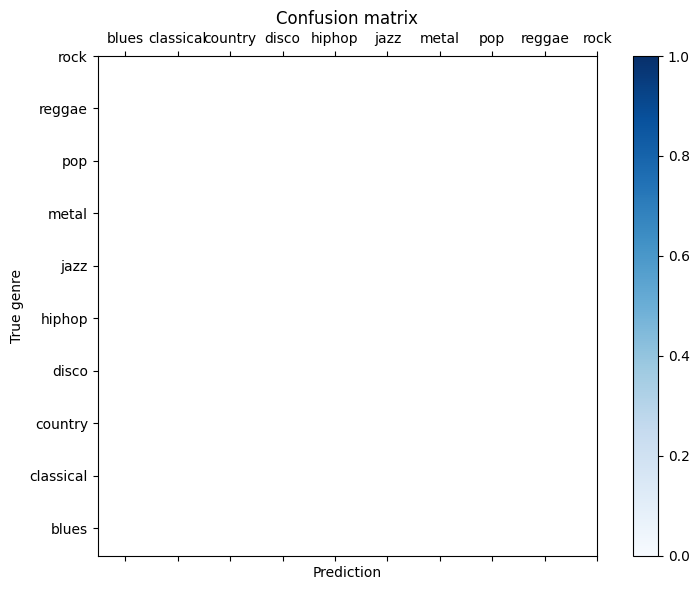

In [ ]:
import matplotlib.pyplot as plt
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print("Confusion Matrix:")

class_names = test_dataset.label_map.keys()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)
# Dodaj etykiety osi
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Dodaj liczby do komórek
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        ax.text(j, i, str(conf_matrix[i][j]),
                va='center', ha='center', color='black', fontsize=12)

# Oznaczenia osi
plt.xlabel('Prediction')
plt.ylabel('True genre')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()


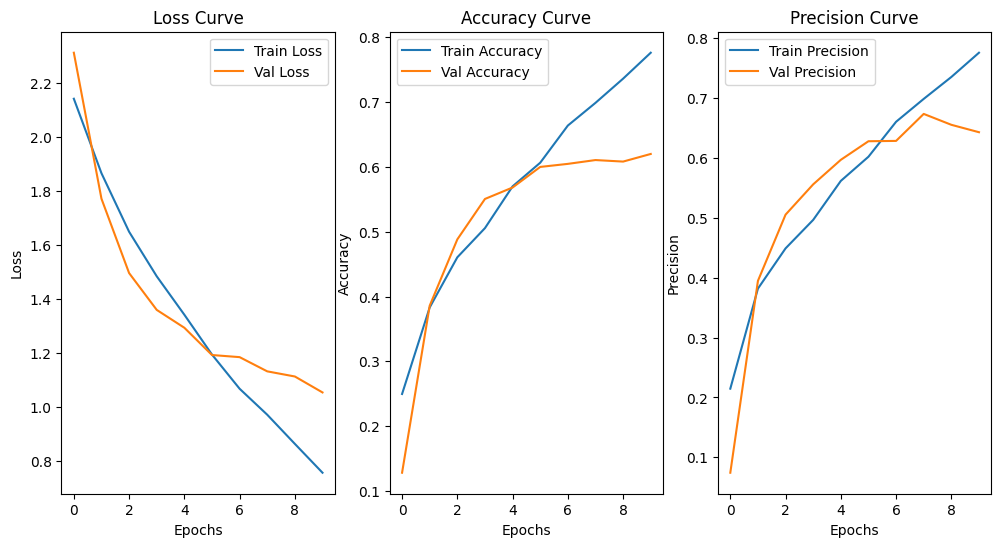

In [36]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(12, 6))

# Losses
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), np.mean(all_metrics['train_loss'], axis=0), label='Train Loss')
plt.plot(range(num_epochs), np.mean(all_metrics['val_loss'], axis=0), label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), np.mean(all_metrics['train_accuracy'], axis=0), label='Train Accuracy')
plt.plot(range(num_epochs), np.mean(all_metrics['val_accuracy'], axis=0), label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), np.mean(all_metrics['train_precision'], axis=0), label='Train Precision')
plt.plot(range(num_epochs), np.mean(all_metrics['val_precision'], axis=0), label='Val Precision')
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.show()

In [37]:

torch.save({
    'epoch': num_epochs,
    'train_accuracies': all_metrics['train_accuracy'],
    'val_accuracies': all_metrics['val_accuracy'],
    'train_losses': all_metrics['train_loss'],
    'val_losses': all_metrics['val_loss'],
    'train_precisions: ': all_metrics['train_precision'],
    'val_precisions': all_metrics['val_precision'],
}, get_filename_with_date())


C:\Users\julia\AppData\Local\Temp\ipykernel_1996\4148138391.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_1 = torch.load('model_21_May_23_16.pth')
C:\Users\

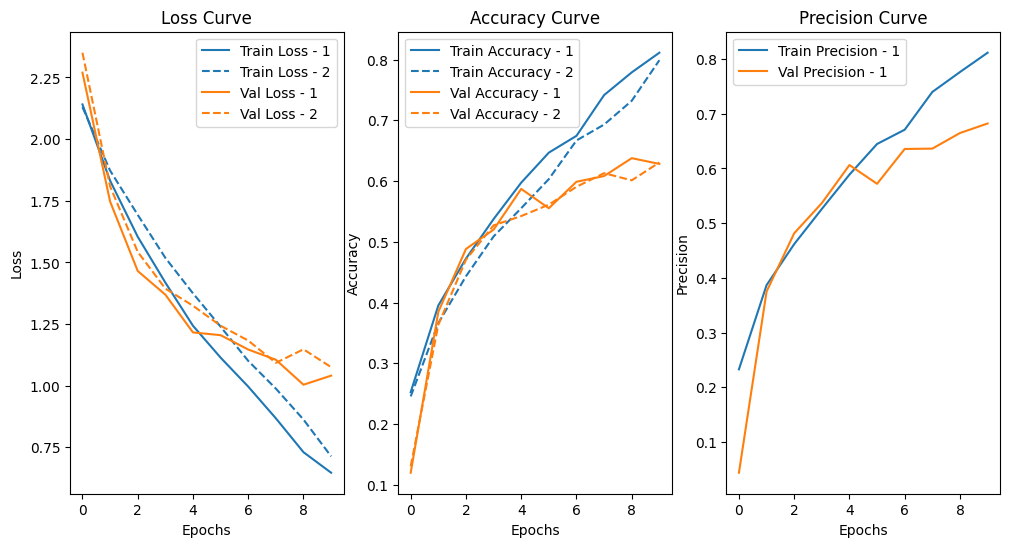

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
checkpoint_1 = torch.load('model_21_May_23_16.pth')
num_epochs = 10
train_losses_1 = checkpoint_1['train_losses']
val_losses_1 = checkpoint_1['val_losses']
train_accuracies_1 = checkpoint_1['train_accuracies']
val_accuracies_1 = checkpoint_1['val_accuracies']
train_precisions_1 = checkpoint_1['train_precisions: ']
val_precisions_1 = checkpoint_1['val_precisions']

checkpoint_2 = torch.load('model_22_May_09_49.pth')
num_epochs = 10
train_losses_2 = checkpoint_2['train_losses']
val_losses_2 = checkpoint_2['val_losses']
train_accuracies_2 = checkpoint_2['train_accuracies']
val_accuracies_2 = checkpoint_2['val_accuracies']
train_precisions_2 = checkpoint_2['train_precisions: ']
val_precisions_2 = checkpoint_2['val_precisions']

# Plotting the Loss and Accuracy curves
plt.figure(figsize=(12, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Losses
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), np.mean(train_losses_1, axis=0), label='Train Loss - 1', color=colors[0], linestyle='-')
plt.plot(range(num_epochs), np.mean(train_losses_2, axis=0), label='Train Loss - 2', color=colors[0], linestyle='--')
plt.plot(range(num_epochs), np.mean(val_losses_1, axis=0), label='Val Loss - 1', color=colors[1], linestyle='-')
plt.plot(range(num_epochs), np.mean(val_losses_2, axis=0), label='Val Loss - 2', color=colors[1], linestyle='--')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), np.mean(train_accuracies_1, axis=0),
         label='Train Accuracy - 1', color=colors[0], linestyle='-')

plt.plot(range(num_epochs), np.mean(train_accuracies_2, axis=0),
         label='Train Accuracy - 2', color=colors[0], linestyle='--')

# Wersja 2
plt.plot(range(num_epochs), np.mean(val_accuracies_1, axis=0),
         label='Val Accuracy - 1', color=colors[1], linestyle='-')

plt.plot(range(num_epochs), np.mean(val_accuracies_2, axis=0),
         label='Val Accuracy - 2', color=colors[1], linestyle='--')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), np.mean(train_precisions_1, axis=0), label='Train Precision - 1')
plt.plot(range(num_epochs), np.mean(val_precisions_1, axis=0), label='Val Precision - 1')
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.show()


In [ ]:
'''

num_classes = 10
model = densenet121()
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load('model.pth'))
model.eval()
success = 0
val_size = 1
for elem in val_dataset:
    image, label = elem
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    _, predicted = torch.max(output, 1)

    if predicted == label:
        success += 1
    val_size += 1
print(success/val_size)

'''

"\n\nnum_classes = 10\nmodel = densenet121()\nmodel.classifier = nn.Linear(model.classifier.in_features, num_classes)\nmodel.load_state_dict(torch.load('model.pth'))\nmodel.eval()\nsuccess = 0\nval_size = 1\nfor elem in val_dataset:\n    image, label = elem\n    with torch.no_grad():\n        output = model(image.unsqueeze(0))\n    _, predicted = torch.max(output, 1)\n\n    if predicted == label:\n        success += 1\n    val_size += 1\nprint(success/val_size)\n\n"